In [2]:
from pyopenms import *
import pandas as pd
import numpy as np
import os
import glob

input_mzml_files = glob.glob('results/interim/*.mzML')

raw_data=[]
for filename in input_mzml_files:
    exp= MSExperiment()
    MzMLFile().load(filename, exp)
    exp.sortSpectra(True)
    raw_data.append(exp)

ref_index = [i[0] for i in sorted(enumerate([exp.size() for exp in raw_data]), key=lambda x:x[1])][-1]
aligner = MapAlignmentAlgorithmPoseClustering()
aligner_par= aligner.getDefaults()
#aligner_par.setValue("max_num_peaks_considered", -1)
aligner.setParameters(aligner_par)
aligner.setReference(raw_data[ref_index])

for exp in raw_data[:ref_index] + raw_data[ref_index+1:]:
    trafo = TransformationDescription()
    aligner.align(exp, trafo)
    transformer = MapAlignmentTransformer()
    transformer.transformRetentionTimes(exp, trafo, True)

for exp in raw_data:    
    mzml_file = os.path.join("results", "", "FFMI", "", "interim", "", 'MapAligned_' + os.path.basename(exp.getLoadedFilePath())[19:-5] +".mzML")
    MzMLFile().store(mzml_file, exp)

In [1]:
from pyopenms import *
import pandas as pd
import numpy as np
import os
import glob
import csv
# read tsv file and create list of FeatureFinderMetaboIdentCompound
def metaboTableFromFile(path_to_library_file):
    metaboTable = []
    with open(path_to_library_file, 'r') as tsv_file:
        tsv_reader = csv.reader(tsv_file, delimiter="\t")
        next(tsv_reader) # skip header
        for row in tsv_reader:
            metaboTable.append(FeatureFinderMetaboIdentCompound(
                row[0], # name
                row[1], # sum formula
                float(row[2]), # mass
                [int(charge) for charge in row[3].split(',')], # charges
                [float(rt) for rt in row[4].split(',')], # RTs
                [float(rt_range) for rt_range in row[5].split(',')], # RT ranges
                [float(iso_distrib) for iso_distrib in row[6].split(',')] # isotope distributions
            ))
    return metaboTable

Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


In [7]:
input_mzml_files=glob.glob("results/FFMI/interim/*.mzML")
# load ms data from mzML file into MSExperiment
for mzml_file in input_mzml_files:
    spectra = MSExperiment()
    MzMLFile().load(mzml_file, spectra)

    # create FeatureFinderAlgorithmMetaboIdent and assign ms data
    ff = FeatureFinderAlgorithmMetaboIdent()
    ff.setMSData(spectra)

    # read library generate a metabo table with compounds
    metabo_table = metaboTableFromFile('epemicins.tsv')

    # FeatureMap to store results
    fm = FeatureMap()

    # edit some parameters
    #reduce RT window (way lower window if process) + peak width
    #process all raw data with Alignment etc - do not overwrite them
    #plot them to see the quality of peaks
    params = ff.getParameters()
    params[b'extract:mz_window'] = 10.0 
    #params[b'model:type']= b'asymmetric'
    params[b'extract:rt_window'] = 100.0
    params[b'detect:peak_width'] = 100.0  #adjust for wide peaks
    ff.setParameters(params)

    # run the FeatureFinderMetaboIdent with the metabo_table and store results in fm
    ff.run(metabo_table, fm)

    # save FeatureMap to file
    ff_file = os.path.join("results", "", "FFMI", "", "interim", "", 'FFMI_' + os.path.basename(mzml_file)[11:-5] +".featureXML")
    FeatureXMLFile().store(ff_file, fm)

RT window size calculated as 240 seconds.
Extracting chromatograms...
Detecting chromatographic peaks...
Found 7 feature candidates in total.
7 features left after selection of best candidates.
2 features left after resolving overlaps (involving 6 features in 1 groups).
Model fitting: 2 successes, 0 failures
Imputing model failures with a linear model based on log(rawIntensities). Slope: 1.08139, Intercept: -1.93055
RT window size calculated as 240 seconds.
Extracting chromatograms...
Detecting chromatographic peaks...
Found 4 feature candidates in total.
4 features left after selection of best candidates.
1 features left after resolving overlaps (involving 4 features in 1 groups).
Model fitting: 1 successes, 0 failures
Imputing model failures with a linear model based on log(rawIntensities). Slope: 1, Intercept: -0.0335543
RT window size calculated as 240 seconds.
Extracting chromatograms...


Found no signal. The Gaussian width is probably smaller than the spacing in your chromatogram data. Try to use a bigger width. The error occurred in the chromatogram with m/z time 1423.830750294896006.


Detecting chromatographic peaks...
Found 6 feature candidates in total.
6 features left after selection of best candidates.
2 features left after resolving overlaps (involving 5 features in 1 groups).
Model fitting: 2 successes, 0 failures
Imputing model failures with a linear model based on log(rawIntensities). Slope: 1.13889, Intercept: -2.4455
RT window size calculated as 240 seconds.
Extracting chromatograms...
Detecting chromatographic peaks...
Found 6 feature candidates in total.
6 features left after selection of best candidates.
2 features left after resolving overlaps (involving 5 features in 1 groups).
Model fitting: 2 successes, 0 failures
Imputing model failures with a linear model based on log(rawIntensities). Slope: 0.995726, Intercept: -0.124051
RT window size calculated as 240 seconds.
Extracting chromatograms...
Detecting chromatographic peaks...
Found 6 feature candidates in total.
6 features left after selection of best candidates.
2 features left after resolving ove

<Found no signal. The Gaussian width is probably smaller than the spacing in your chromatogram data. Try to use a bigger width. The error occurred in the chromatogram with m/z time 712.418579884739756.> occurred 2 times
Found no signal. The Gaussian width is probably smaller than the spacing in your chromatogram data. Try to use a bigger width. The error occurred in the chromatogram with m/z time 712.418762990208506.
<Found no signal. The Gaussian width is probably smaller than the spacing in your chromatogram data. Try to use a bigger width. The error occurred in the chromatogram with m/z time 1423.830750294896006.> occurred 2 times
Found no signal. The Gaussian width is probably smaller than the spacing in your chromatogram data. Try to use a bigger width. The error occurred in the chromatogram with m/z time 712.418824025364756.
Found no signal. The Gaussian width is probably smaller than the spacing in your chromatogram data. Try to use a bigger width. The error occurred in the chro

RuntimeError: the range of the operation was invalid

In [1]:
from collections import defaultdict
from functools import reduce
from pathlib import Path
from time import perf_counter
import sys

from IPython.core.display import display
from pandas import CategoricalDtype
import numpy as np
from pyopenms import *
import pandas as pd
import os

common_meta_value_types = {
    b'label': 'U30',
    b'spectrum_index': 'i',
    b'score_fit': 'f',
    b'score_correlation': 'f',
    b'FWHM': 'f',
    b'spectrum_native_id': 'U30',
    b"num_of_masstraces" : "f"
}

class FeatureMapDF(FeatureMap):
    def __init__(self):
        super().__init__()
    
    # meta_values = None (default), 'all' or list of meta value names
    def get_df(self, meta_values = None):
        # get all possible meta value keys in a set
        if meta_values == 'all':
            meta_values = set()
            for f in self:
                mvs = []
                f.getKeys(mvs)
                for m in mvs:
                    meta_values.add(m)
        elif not meta_values: # if None, set to empty list
            meta_values = []
        
        def gen(fmap: FeatureMap, fun):
            for f in fmap:
                yield from fun(f, meta_values)

        def extract_meta_data(f: Feature, meta_values):
            pep = f.getPeptideIdentifications()  # type: list[PeptideIdentification]
            bb = f.getConvexHull().getBoundingBox2D()
                
            vals = [f.getMetaValue(m) if f.metaValueExists(m) else np.NA for m in meta_values]   # find some NA or None value for numpy
            
            if len(pep) != 0:
                hits = pep[0].getHits()

                if len(hits) != 0:
                    besthit = hits[0]  # type: PeptideHit
                    yield f.getUniqueId(), besthit.getSequence().toString(), f.getCharge(), f.getRT(), f.getMZ(), bb[0][0], bb[1][0], f.getMetaValue("PeptideRef"), f.getOverallQuality(), f.getIntensity()
                else:
                    yield f.getUniqueId(), None, f.getCharge(), f.getRT(), f.getMZ(), bb[0][0], bb[1][0], f.getMetaValue("PeptideRef"), f.getOverallQuality(), f.getIntensity()
            else:
                yield f.getUniqueId(), None, f.getCharge(), f.getRT(), f.getMZ(), bb[0][0], bb[1][0], f.getMetaValue("PeptideRef"), f.getOverallQuality(), f.getIntensity()

        cnt = self.size()

        mddtypes = [('id', np.dtype('uint64')), ('sequence', 'U200'), ('charge', 'i4'), ('RT', 'f'), ('mz', 'f'),
                    ('RTstart', 'f'), ('RTend', 'f'), ("PeptideRef", 'U200'),
                    ('quality', 'f'), ('intensity', 'f')]
        
        for meta_value in meta_values:
            if meta_value in common_meta_value_types:
                mddtypes.append((meta_value.decode(), common_meta_value_types[meta_value]))
            else:
                mddtypes.append((meta_value.decode(), 'U50'))
        mdarr = np.fromiter(iter=gen(self, extract_meta_data), dtype=mddtypes, count=cnt)
        df= pd.DataFrame(mdarr).set_index('id').sort_values("mz").drop(columns= "sequence")
        return df

In [ ]:
input_feature_files = glob.glob('results/FFMI/interim/*.featureXML')

for filename in input_feature_files:
    fmap = FeatureMapDF()
    FeatureXMLFile().load(filename, fmap)
    DF= fmap.get_df()
    feature_csv= os.path.join("results", "", "FFMI", "", 'features_' + os.path.basename(filename)[:-10] +"csv")
    DF.to_csv(feature_csv)
    print(os.path.basename(filename))
    display(DF)

Error: Session cannot generate requests

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

filename = 'results/FFMI/interim/FFMI_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_blank.featureXML'

def plotDetectedFeatures3D(path_to_featureXML):
    fm = FeatureMap()
    fh = FeatureXMLFile()
    fh.load(path_to_featureXML, fm)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for feature in fm:
        color = next(ax._get_lines.prop_cycler)['color']
        # chromatogram data is stored in the subordinates of the feature
        for i, sub in enumerate(feature.getSubordinates()):
            retention_times = [x[0] for x in sub.getConvexHulls()[0].getHullPoints()]
            intensities = [int(y[1]) for y in sub.getConvexHulls()[0].getHullPoints()]
            mz = sub.getMetaValue('MZ')
            ax.plot(retention_times, intensities, zs = mz, zdir = 'x', color = color)
            if i == 0:
                ax.text(mz,retention_times[0], max(intensities)*1.02, feature.getMetaValue('label'), color = color)

    ax.set_ylabel('time (s)')
    ax.set_xlabel('m/z')
    ax.set_zlabel('intensity (cps)')
    plt.show()


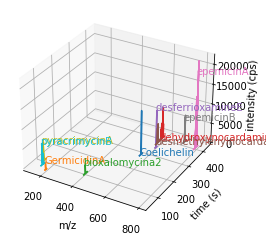

In [17]:
plotDetectedFeatures3D(filename)